# "Moving Pictures" tutorial

**_note:_ this tutorial is an adaptation of the same tutorial that may be found on the [official QIIME 2 docs website](https://docs.qiime2.org/2019.10/tutorials/moving-pictures/). The original tutorial uses the QIIME 2 CLI interface.**
  
**The notebook was tested using the `2019.10` version of QIIME 2.**

In this tutorial you’ll use QIIME 2 to perform an analysis of human microbiome samples from two individuals at four body sites at five timepoints, the first of which immediately followed antibiotic usage. A study based on these samples was originally published in Caporaso et al. (2011). The data used in this tutorial were sequenced on an Illumina HiSeq using the Earth Microbiome Project hypervariable region 4 (V4) 16S rRNA sequencing protocol.

## before you start:

**close this notebook and jupyter session, and run `jupyter serverextension enable --py qiime2 --sys-prefix`  
Then, restart this notebook**

Let's import all necessary modules

In [1]:
%matplotlib inline
import qiime2
from tempfile import mkdtemp
from qiime2.plugins import demux, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition

/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Library/anaconda/envs/qiime2-2019.10

Before beginning this tutorial, create a new directory and change to that directory.

**make sure to change the path in workdir**

In [8]:
workdir='/Users/tomasz/tmp/qiime2-moving-pictures-tutorial'

In [11]:
!mkdir -p $workdir
!cd $workdir

## Sample metadata

Before starting the analysis, explore the sample metadata to familiarize yourself with the samples used in this study. The sample metadata is available as a Google Sheet. You can download this file as tab-separated text by selecting File > Download as > Tab-separated values. Alternatively, the following command will download the sample metadata as tab-separated text and save it in the file sample-metadata.tsv. This sample-metadata.tsv file is used throughout the rest of the tutorial.

In [12]:
!wget -O $workdir/"sample-metadata.tsv" "https://data.qiime2.org/2019.10/tutorials/moving-pictures/sample_metadata.tsv"

--2020-02-06 20:20:47--  https://data.qiime2.org/2019.10/tutorials/moving-pictures/sample_metadata.tsv
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://docs.google.com/spreadsheets/d/16oomVnULW-uesehNZc_mKIDTnuRoTiun0CpzSFZagvo/export?gid=0&format=tsv [following]
--2020-02-06 20:20:48--  https://docs.google.com/spreadsheets/d/16oomVnULW-uesehNZc_mKIDTnuRoTiun0CpzSFZagvo/export?gid=0&format=tsv
Resolving docs.google.com (docs.google.com)... 216.58.209.14
Connecting to docs.google.com (docs.google.com)|216.58.209.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘/Users/tomasz/tmp/qiime2-moving-pictures-tutorial/sample-metadata.tsv’

/Users/tomasz/tmp/q     [ <=>                ]   2.04K  --.-KB/s    in 0s      

2020-02-06 20:20:49 (11.8 MB/s) - ‘/Users/

## Obtaining and importing data

Download the sequence reads that we’ll use in this analysis. In this tutorial we’ll work with a small subset of the complete sequence data so that the commands will run quickly.


In [13]:
!mkdir $workdir/emp-single-end-sequences

In [14]:
!wget -O $workdir/"emp-single-end-sequences/barcodes.fastq.gz" "https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz"

--2020-02-06 20:20:56--  https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz [following]
--2020-02-06 20:20:57--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.249.16
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.249.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783785 (3.6M) [application/x-gzip]
Saving to: ‘/Users/tomasz/tmp/qiime2-moving-pictures-tutorial/emp-single-end-sequences/barcodes.fastq.gz’

/User

In [15]:
!wget -O $workdir/"emp-single-end-sequences/sequences.fastq.gz" "https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz"

--2020-02-06 20:21:07--  https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz [following]
--2020-02-06 20:21:08--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.249.16
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.249.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25303756 (24M) [binary/octet-stream]
Saving to: ‘/Users/tomasz/tmp/qiime2-moving-pictures-tutorial/emp-single-end-sequences/sequences.fastq.gz’



### import data as a qiime2 artifact

All data that is used as input to QIIME 2 is in form of QIIME 2 artifacts, which contain information about the type of data and the source of the data. So, the first thing we need to do is import these sequence data files into a QIIME 2 artifact.

The semantic type of this QIIME 2 artifact is EMPSingleEndSequences. EMPSingleEndSequences QIIME 2 artifacts contain sequences that are multiplexed, meaning that the sequences have not yet been assigned to samples (hence the inclusion of both sequences.fastq.gz and barcodes.fastq.gz files, where the barcodes.fastq.gz contains the barcode read associated with each sequence in sequences.fastq.gz.) To learn about how to import sequence data in other formats, see the importing data tutorial.


In [16]:
single_end_sequences = qiime2.Artifact.import_data('EMPSingleEndSequences', workdir+'/emp-single-end-sequences/')

### read metadata into qiime2.Metadata object

In [17]:
sample_metadata = qiime2.Metadata.load(workdir+'/sample-metadata.tsv')

## Demultiplexing sequences 

To demultiplex sequences we need to know which barcode sequence is associated with each sample. This information is contained in the sample metadata file. You can run the following commands to demultiplex the sequences (the demux emp-single command refers to the fact that these sequences are barcoded according to the Earth Microbiome Project protocol, and are single-end reads). The demux.qza QIIME 2 artifact will contain the demultiplexed sequences.

In [18]:
demux_sequences = demux.methods.emp_single(single_end_sequences,
                                           sample_metadata.get_column('barcode-sequence'))

After demultiplexing, it’s useful to generate a summary of the demultiplexing results. This allows you to determine how many sequences were obtained per sample, and also to get a summary of the distribution of sequence qualities at each position in your sequence data.

<visualization: Visualization uuid: 2b5b3373-cb5e-442c-a69c-9af62152520f>

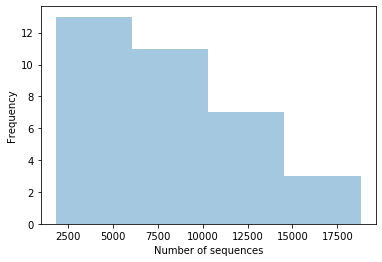

In [19]:
demux_summary = demux.visualizers.summarize(demux_sequences.per_sample_sequences)
demux_summary.visualization


## Sequence quality control and feature table construction

QIIME 2 plugins are available for several quality control methods, including DADA2, Deblur, and basic quality-score-based filtering. In this tutorial we present this step using DADA2 and Deblur. These steps are interchangeable, so you can use whichever of these you prefer. The result of both of these methods will be a FeatureTable[Frequency] QIIME 2 artifact, which contains counts (frequencies) of each unique sequence in each sample in the dataset, and a FeatureData[Sequence] QIIME 2 artifact, which maps feature identifiers in the FeatureTable to the sequences they represent.

## Option 1: DADA2

skipped

## Option 2: Deblur

Deblur uses sequence error profiles to associate erroneous sequence reads with the true biological sequence from which they are derived, resulting in high quality sequence variant data. This is applied in two steps. First, an initial quality filtering process based on quality scores is applied. This method is an implementation of the quality filtering approach described by Bokulich et al. (2013).

In [20]:
demux_filter_stats = quality_filter.methods.q_score(demux_sequences.per_sample_sequences)

/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/q2_quality_filter/_filter.py:88: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  phred_offset = yaml.load(metadata_view)['phred-offset']


Next, the Deblur workflow is applied using the qiime deblur denoise-16S method. This method requires one parameter that is used in quality filtering, --p-trim-length n which truncates the sequences at position n. In general, the Deblur developers recommend setting this value to a length where the median quality score begins to drop too low. On these data, the quality plots (prior to quality filtering) suggest a reasonable choice is in the 115 to 130 equence position range. This is a subjective assessment. One situation where you might deviate from that ecommendation is when performing a meta-analysis across multiple sequencing runs. In this type of meta-analysis, it is critical that the read lengths be the same for all of the sequencing runs being compared to avoid introducing a study-specific bias. Since we already using a trim length of 120 for qiime dada2 denoise-single, and since 120 is reasonable given the quality plots, we’ll pass --p-trim-length 120. This next command may take up to 10 minutes to run.

In [21]:
deblur_sequences = deblur.methods.denoise_16S(demux_sequences.per_sample_sequences,
                                              trim_length=120,
                                              sample_stats=True)

In [22]:
filter_stats = metadata.visualizers.tabulate(demux_filter_stats.filter_stats.view(qiime2.Metadata))
filter_stats.visualization

<visualization: Visualization uuid: a885e004-c1fb-4b9d-9122-c04518ce36b7>

In [23]:
deblur_stats = deblur.visualizers.visualize_stats(deblur_sequences.stats)
deblur_stats.visualization

<visualization: Visualization uuid: dd2f4677-de46-448d-9f79-efffeecaafb5>


## FeatureTable and FeatureData summaries

After the quality filtering step completes, you’ll want to explore the resulting data. You can do this using the following two commands, which will create visual summaries of the data. The feature-table summarize command will give you information on how many sequences are associated with each sample and with each feature, histograms of those distributions, and some related summary statistics. The feature-table tabulate-seqs command will provide a mapping of feature IDs to sequences, and provide links to easily BLAST each sequence against the NCBI nt database. The latter visualization will be very useful later in the tutorial, when you want to learn more about specific features that are important in the data set.


/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:122: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'sample-frequency-detail.csv'))
/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:124: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'feature-frequency-detail.csv'))


<visualization: Visualization uuid: 8057d39a-bb5b-4c17-9788-1c5216a30753>

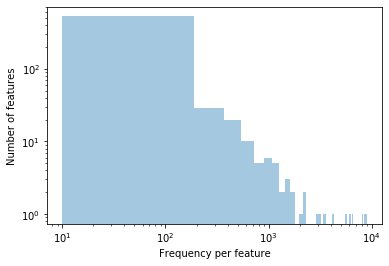

In [24]:
output_viz = feature_table.visualizers.summarize(deblur_sequences.table)
output_viz.visualization

In [25]:
deblur_feature_table_summary = feature_table.visualizers.tabulate_seqs(deblur_sequences.representative_sequences)
deblur_feature_table_summary.visualization

<visualization: Visualization uuid: 6645ffaa-9bf6-4677-a639-1b5976e95538>


## Generate a tree for phylogenetic diversity analyses

QIIME supports several phylogenetic diversity metrics, including Faith’s Phylogenetic Diversity and weighted and unweighted UniFrac. In addition to counts of features per sample (i.e., the data in the `FeatureTable[Frequency]` QIIME 2 artifact), these metrics require a rooted phylogenetic tree relating the features to one another. This information will be stored in a `Phylogeny[Rooted]` QIIME 2 artifact. To generate a phylogenetic tree we will use `align-to-tree-mafft-fasttree` pipeline from the `q2-phylogeny` plugin.

First, the pipeline uses the `mafft` program to perform a multiple sequence alignment of the sequences in our `FeatureData[Sequence]` to create a `FeatureData[AlignedSequence]` QIIME 2 artifact. Next, the pipeline masks (or filters) the alignment to remove positions that are highly variable. These positions are generally considered to add noise to a resulting phylogenetic tree. Following that, the pipeline applies FastTree to generate a phylogenetic tree from the masked alignment. The FastTree program creates an unrooted tree, so in the final step in this section midpoint rooting is applied to place the root of the tree at the midpoint of the longest tip-to-tip distance in the unrooted tree.

In [30]:
rooted_tree = phylogeny.pipelines.align_to_tree_mafft_fasttree(deblur_sequences.representative_sequences)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /var/folders/d9/9kc5j9rs5gxby38zjt802kh80000gn/T/qiime2-archive-0ugn95dk/c0993402-61c2-4805-b45f-4c9a4f5ac737/data/dna-sequences.fasta

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /var/folders/d9/9kc5j9rs5gxby38zjt802kh80000gn/T/qiime2-archive-nvwh0gcn/9dbe9986-1f02-4bb6-8327-02f0f4bf1ef4/data/aligned-dna-sequences.fasta



## Alpha and beta diversity analysis

QIIME 2’s diversity analyses are available through the `q2-diversity` plugin, which supports computing alpha and beta diversity metrics, applying related statistical tests, and generating interactive visualizations. We’ll first apply the `core-metrics-phylogenetic` method, which rarefies a `FeatureTable[Frequency]` to a user-specified depth, computes several alpha and beta diversity metrics, and generates principle coordinates analysis (PCoA) plots using Emperor for each of the beta diversity metrics. The metrics computed by default are:

* Alpha diversity
    * Shannon’s diversity index (a quantitative measure of community richness)
    * Observed OTUs (a qualitative measure of community richness)
    * Faith’s Phylogenetic Diversity (a qualitiative measure of community richness that incorporates phylogenetic relationships between the features)
    * Evenness (or Pielou’s Evenness; a measure of community evenness)

* Beta diversity
    * Jaccard distance (a qualitative measure of community dissimilarity)
    * Bray-Curtis distance (a quantitative measure of community dissimilarity)
    * unweighted UniFrac distance (a qualitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)
    * weighted UniFrac distance (a quantitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)

An important parameter that needs to be provided to this script is `sampling-depth`, which is the even sampling (i.e. rarefaction) depth. Because most diversity metrics are sensitive to different sampling depths across different samples, this script will randomly subsample the counts from each sample to the value provided for this parameter. For example, if you provide `sampling-depth=500`, this step will subsample the counts in each sample without replacement so that each sample in the resulting table has a total count of 500. If the total count for any sample(s) are smaller than this value, those samples will be dropped from the diversity analysis. Choosing this value is tricky. We recommend making your choice by reviewing the information presented in the table that was created above. Choose a value that is as high as possible (so you retain more sequences per sample) while excluding as few samples as possible.

In [31]:
core_metrics = diversity.pipelines.core_metrics_phylogenetic(table = deblur_sequences.table,
                                                             phylogeny = rooted_tree.rooted_tree,
                                                             sampling_depth = 1103,
                                                             metadata = sample_metadata)

/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01802006913632016 and the largest is 3.5959166404037264.
  RuntimeWarning
/Library/anaconda/envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the

Here we set the `sampling-depth` parameter to 1103. This value was chosen based on the number of sequences in the L3S313 sample because it’s close to the number of sequences in the next few samples that have higher sequence counts, and because it is considerably higher (relatively) than the number of sequences in the samples that have fewer sequences. This will allow us to retain most of our samples. The three samples that have fewer sequences will be dropped from the `core-metrics-phylogenetic` analyses and anything that uses these results. It is worth noting that all three of these samples are “right palm” samples. Losing a disproportionate number of samples from one metadata category is not ideal. However, we are dropping a small enough number of samples here that this felt like the best compromise between total sequences analyzed and number of samples retained.


### alpha group significance

After computing diversity metrics, we can begin to explore the microbial composition of the samples in the context of the sample metadata. This information is present in the sample metadata file that was downloaded earlier.

We’ll first test for associations between categorical metadata columns and alpha diversity data. We’ll do that here for the Faith Phylogenetic Diversity (a measure of community richness) and evenness metrics.

In [32]:
faith_pd_group_significance = diversity.actions.alpha_group_significance(core_metrics.faith_pd_vector,
                                                                         sample_metadata)

In [33]:
evenness_group_significance = diversity.actions.alpha_group_significance(core_metrics.evenness_vector,
                                                                         sample_metadata)


Visualize group significance results

In [34]:
faith_pd_group_significance.visualization

<visualization: Visualization uuid: c2d38a98-5003-43cf-96b0-073f3726aa40>

In [35]:
evenness_group_significance.visualization

<visualization: Visualization uuid: cef95a80-6b57-4dfe-8fd2-af58c5515a2a>


### beta group significance

In this data set, no continuous sample metadata columns (e.g., `days-since-experiment-start`) are correlated with alpha diversity, so we won’t test for those associations here. If you’re interested in performing those tests (for this data set, or for others), you can use the `diversity.visualizers.alpha-correlation` command.

Next we’ll analyze sample composition in the context of categorical metadata using PERMANOVA (first described in Anderson (2001)) using the beta-group-significance command. The following commands will test whether distances between samples within a group, such as samples from the same body site (e.g., gut), are more similar to each other then they are to samples from the other groups (e.g., tongue, left palm, and right palm). If you call this command with the --p-pairwise parameter, as we’ll do here, it will also perform pairwise tests that will allow you to determine which specific pairs of groups (e.g., tongue and gut) differ from one another, if any. This command can be slow to run, especially when passing --p-pairwise, since it is based on permutation tests. So, unlike the previous commands, we’ll run this on specific columns of metadata that we’re interested in exploring, rather than all metadata columns that it’s applicable to. Here we’ll apply this to our unweighted UniFrac distances, using two sample metadata columns, as follows.

In [36]:
uUniFrac_BodySite_significance = diversity.actions.beta_group_significance(core_metrics.unweighted_unifrac_distance_matrix,
                                                                           sample_metadata.get_column('body-site'))

<Figure size 432x288 with 0 Axes>

In [37]:
uUniFrac_Subject_significance = diversity.actions.beta_group_significance(core_metrics.unweighted_unifrac_distance_matrix,
                                                                          sample_metadata.get_column('subject'))

<Figure size 432x288 with 0 Axes>

In [39]:
uUniFrac_BodySite_significance.visualization

<visualization: Visualization uuid: 60980d92-4437-4ba8-ac35-f3a6987e16db>

In [40]:
uUniFrac_Subject_significance.visualization

<visualization: Visualization uuid: 155abd34-2935-4a9c-a6c3-e90071c3f813>

Again, none of the continuous sample metadata that we have for this data set are correlated with sample composition, so we won’t test for those associations here. If you’re interested in performing those tests, you can use the `metadata.visualizers.distance_matrix` in combination with `diversity.visualizers.mantel` and `diversity.visualizers.bioenv` commands.

Finally, ordination is a popular approach for exploring microbial community composition in the context of sample metadata. We can use the [Emperor](http://biocore.github.io/emperor/) tool to explore principal coordinates (PCoA) plots in the context of sample metadata. While our core-metrics-phylogenetic command did already generate some Emperor plots, we want to pass an optional parameter, `custom-axes`, which is very useful for exploring time series data. The PCoA results that were used in `core-metrics-phylogeny` are also available, making it easy to generate new visualizations with Emperor. We will generate Emperor plots for unweighted UniFrac and Bray-Curtis so that the resulting plot will contain axes for principal coordinate 1, principal coordinate 2, and days since the experiment start. We will use that last axis to explore how these samples changed over time.

In [41]:
emperor_plot_unifrac = emperor.visualizers.plot(core_metrics.unweighted_unifrac_pcoa_results,
                                                sample_metadata,
                                                custom_axes=['days-since-experiment-start'])
emperor_plot_unifrac.visualization

<visualization: Visualization uuid: 117ca9b1-9af1-433f-b136-3f90e5c4443a>

In [42]:
emperor_plot_bc = emperor.visualizers.plot(core_metrics.bray_curtis_pcoa_results,
                                           sample_metadata,
                                           custom_axes=['days-since-experiment-start'])
emperor_plot_bc.visualization

<visualization: Visualization uuid: c65ec205-3254-4b44-bb84-307dd48a3f88>


## Alpha rarefaction plotting

In this section we’ll explore alpha diversity as a function of sampling depth using the qiime diversity alpha-rarefaction visualizer. This visualizer computes one or more alpha diversity metrics at multiple sampling depths, in steps between 1 (optionally controlled with --p-min-depth) and the value provided as --p-max-depth. At each sampling depth step, 10 rarefied tables will be generated, and the diversity metrics will be computed for all samples in the tables. The number of iterations (rarefied tables computed at each sampling depth) can be controlled with --p-iterations. Average diversity values will be plotted for each sample at each even sampling depth, and samples can be grouped based on metadata in the resulting visualization if sample metadata is provided with the --m-metadata-file parameter.

In [43]:
alpha_rarefaction = diversity.actions.alpha_rarefaction(table = deblur_sequences.table,
                                                        max_depth = 4000,
                                                        phylogeny = rooted_tree.rooted_tree,
                                                        metadata = sample_metadata)

In [43]:
alpha_rarefaction.visualization

<visualization: Visualization uuid: a55f6de9-5c2c-45c1-97ca-79df849b7277>

The visualization will have two plots. The top plot is an alpha rarefaction plot, and is primarily used to determine if the richness of the samples has been fully observed or sequenced. If the lines in the plot appear to “level out” (i.e., approach a slope of zero) at some sampling depth along the x-axis, that suggests that collecting additional sequences beyond that sampling depth would not be likely to result in the observation of additional features. If the lines in a plot don’t level out, this may be because the richness of the samples hasn’t been fully observed yet (because too few sequences were collected), or it could be an indicator that a lot of sequencing error remains in the data (which is being mistaken for novel diversity).

The bottom plot in this visualization is important when grouping samples by metadata. It illustrates the number of samples that remain in each group when the feature table is rarefied to each sampling depth. If a given sampling depth d is larger than the total frequency of a sample s (i.e., the number of sequences that were obtained for sample s), it is not possible to compute the diversity metric for sample s at sampling depth d. If many of the samples in a group have lower total frequencies than d, the average diversity presented for that group at d in the top plot will be unreliable because it will have been computed on relatively few samples. When grouping samples by metadata, it is therefore essential to look at the bottom plot to ensure that the data presented in the top plot is reliable.


## Taxonomic analysis

In the next sections we’ll begin to explore the taxonomic composition of the samples, and again relate that to sample metadata. The first step in this process is to assign taxonomy to the sequences in our FeatureData[Sequence] QIIME 2 artifact. We’ll do that using a pre-trained Naive Bayes classifier and the q2-feature-classifier plugin. This classifier was trained on the Greengenes 13_8 99% OTUs, where the sequences have been trimmed to only include 250 bases from the region of the 16S that was sequenced in this analysis (the V4 region, bound by the 515F/806R primer pair). We’ll apply this classifier to our sequences, and we can generate a visualization of the resulting mapping from sequence to taxonomy.

In [44]:
!wget -O $workdir"/gg-13-8-99-515-806-nb-classifier.qza" "https://data.qiime2.org/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza"

--2020-01-31 19:28:39--  https://data.qiime2.org/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza [following]
--2020-01-31 19:28:40--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.249.112
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.249.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28373760 (27M) [binary/octet-stream]
Saving to: ‘/home/katarzyna/Desktop/qiime2-moving-pictures-tutorial/gg-13-8-99-515-806-nb-classifier.qza’

/home/katarzyna/Des 100%[===================>]  27,06M  6,84MB/s    in 4,0s  

unfortunately you have to do this first:

In [46]:
!qiime tools export --input-path $workdir/'gg-13-8-99-515-806-nb-classifier.qza' --output-path $workdir/classifier

Exported /home/katarzyna/Desktop/qiime2-moving-pictures-tutorial/gg-13-8-99-515-806-nb-classifier.qza as TaxonomicClassiferTemporaryPickleDirFmt to directory /home/katarzyna/Desktop/qiime2-moving-pictures-tutorial/classifier


In [47]:
gg_classifier = qiime2.Artifact.import_data('TaxonomicClassifier', workdir+'/classifier/')

In [48]:
taxonomy = feature_classifier.methods.classify_sklearn(reads = deblur_sequences.representative_sequences,
                                                       classifier = gg_classifier)

In [49]:
taxonomy_classification = metadata.visualizers.tabulate(taxonomy.classification.view(qiime2.Metadata))
taxonomy_classification.visualization

<visualization: Visualization uuid: da86e1a2-a732-4c7e-bc3b-33eed54d083f>

Next, we can view the taxonomic composition of our samples with interactive bar plots. Generate those plots with the following command and then open the visualization.

In [50]:
taxa_bar_plot = taxa.visualizers.barplot(deblur_sequences.table, taxonomy.classification, sample_metadata)
taxa_bar_plot.visualization

<visualization: Visualization uuid: 1e23f4ba-6425-425f-a28c-a97dee477f10>


## Differential abundance testing with ANCOM

ANCOM can be applied to identify features that are differentially abundant (i.e. present in different abundances) across sample groups. As with any bioinformatics method, you should be aware of the assumptions and limitations of ANCOM before using it. We recommend reviewing the ANCOM paper before using this method.

ANCOM is implemented in the q2-composition plugin. ANCOM assumes that few (less than about 25%) of the features are changing between groups. If you expect that more features are changing between your groups, you should not use ANCOM as it will be more error-prone (an increase in both Type I and Type II errors is possible). Because we expect a lot of features to change in abundance across body sites, in this tutorial we’ll filter our full feature table to only contain gut samples. We’ll then apply ANCOM to determine which, if any, sequence variants and genera are differentially abundant across the gut samples of our two subjects.

We’ll start by creating a feature table that contains only the gut samples. (To learn more about filtering, see the Filtering Data tutorial.)

In [60]:
gut_deblur = feature_table.methods.filter_samples(deblur_sequences.table,
                                                  metadata = sample_metadata,
                                                  where = "[body-site]='gut'")

ANCOM operates on a FeatureTable[Composition] QIIME 2 artifact, which is based on frequencies of features on a per-sample basis, but cannot tolerate frequencies of zero. To build the composition artifact, a FeatureTable[Frequency] artifact must be provided to add-pseudocount (an imputation method), which will produce the FeatureTable[Composition] artifact.

In [61]:
gut_deblur_composition = composition.actions.add_pseudocount(gut_deblur.filtered_table)
ancom_gut_deblur = composition.actions.ancom(table = gut_deblur_composition.composition_table,
                                             metadata = sample_metadata.get_column('subject'))

/home/katarzyna/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


In [62]:
ancom_gut_deblur.visualization

<visualization: Visualization uuid: 6ecc2a2b-1360-4ae1-abe6-4e48a37eafef>

We’re also often interested in performing a differential abundance test at a specific taxonomic level. To do this, we can collapse the features in our FeatureTable[Frequency] at the taxonomic level of interest, and then re-run the above steps. In this tutorial, we collapse our feature table at the genus level (i.e. level 6 of the Greengenes taxonomy).

We’re also often interested in performing a differential abundance test at a specific taxonomic level. To do this, we can collapse the features in our FeatureTable[Frequency] at the taxonomic level of interest, and then re-run the above steps. In this tutorial, we collapse our feature table at the genus level (i.e. level 6 of the Greengenes taxonomy).

In [63]:
gut_table_l6 = taxa.methods.collapse(table = gut_deblur.filtered_table,
                                     taxonomy = taxonomy.classification,
                                     level = 6)

In [64]:
gut_table_l6_composition = composition.actions.add_pseudocount(gut_table_l6.collapsed_table)

ancom_gut_table_l6 = composition.actions.ancom(table = gut_table_l6_composition.composition_table,
                                               metadata = sample_metadata.get_column('subject'))

In [65]:
ancom_gut_table_l6.visualization

<visualization: Visualization uuid: 6fa5cde2-724a-490b-8d29-e325feade7fc>